In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LassoCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    mean_squared_error,
    accuracy_score,
    multilabel_confusion_matrix,
    plot_confusion_matrix,
    roc_auc_score,
    roc_curve,
    auc
)

<b>Data Processing<b>

In [ ]:
joined_data = pd.read_csv(r'joined_data.csv', index_col=False)
joined_data['new_genres'] = joined_data['new_genres'].str.strip()

print(joined_data.info())

print(joined_data['new_genres'].value_counts())

genres_master_list = ['rock', 'pop', 'hip hop', 'classical', 'country', 'alternative', 'jazz', 'edm', 'metal']

equal_dist_df = pd.DataFrame(columns=joined_data.columns)

# select random sample of 4000 rows per genre to normalize distribution
for genre in genres_master_list:
    rows_of_genre = joined_data.loc[joined_data['new_genres'] == genre].sample(4000)
    equal_dist_df = equal_dist_df.append(rows_of_genre)

print(equal_dist_df['new_genres'].value_counts())

equal_dist_df = equal_dist_df.drop(["id", "name", "release_date", "mode", 'duration_ms', 'liveness', 'key'], axis = 1)

Y = equal_dist_df[equal_dist_df.columns[-1]]
X = equal_dist_df.drop(columns=[equal_dist_df.columns[-1]])

scaler = StandardScaler()
scaler.fit(X.values)

X_scaled = scaler.transform(X.values)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, Y, test_size=.25)

Random Forest to Generate Feature Importance Rankings

In [ ]:
# Get feature importance
# n_trees = [50, 100, 150, 300, 500]

# for n in n_trees:

rf = RandomForestClassifier().fit(X_train, y_train)
test_pred = rf.predict(X_test)
train_pred = rf.predict(X_train)

test_acc = (accuracy_score(test_pred, y_test))
test_error = 1 - test_acc
train_acc = (accuracy_score(train_pred, y_train))
train_error = (1 - train_acc)
test_prec = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
train_prec = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')

print("Test Accuracy:", test_acc)
print("Test Error:", test_error)
print("Test Recall:", test_recall)
print("Test Precision:", test_prec)
print("-----------------------------------------")
print("Train Accuracy:", train_acc)
print("Train Error:", train_error)
print("Train Recall:", train_recall)
print("Train Precision:", train_prec)
print("-----------------------------------------")

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
         axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
print("\n")
print(X.columns)

Random Grid Search CV to Find Optimal Parameters

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state = 42).fit(X_train, y_train)

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(5, 200, num = 11)]
max_depth.append(None)

# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)

# Fit the model
rfc_random.fit(X_train, y_train)

# print results
print(rfc_random.best_params_)

Random Forest with Optimal Parameters

In [ ]:
rf = RandomForestClassifier(n_estimators = 555, max_features = 'auto', max_depth = 24, random_state = 4).fit(X_train, y_train)
test_pred = rf.predict(X_test)
train_pred = rf.predict(X_train)

test_acc = (accuracy_score(test_pred, y_test))
test_error = 1 - test_acc
train_acc = (accuracy_score(train_pred, y_train))
train_error = (1 - train_acc)
test_prec = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
train_prec = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')

print("Test Accuracy:", test_acc)
print("Test Error:", test_error)
print("Test Recall:", test_recall)
print("Test Precision:", test_prec)
print("-----------------------------------------")
print("Train Accuracy:", train_acc)
print("Train Error:", train_error)
print("Train Recall:", train_recall)
print("Train Precision:", train_prec)
print("-----------------------------------------")

print("Training snapshot")
df = pd.DataFrame({"Actual": y_train, "Predicted": train_pred})
print(df.head())
print("Training classification report:")
print(classification_report(y_train, train_pred, labels=genres_master_list))

print("Testing snapshot")
df = pd.DataFrame({"Actual": y_test, "Predicted": test_pred})
print(df.head())
print("Testing classification report:")
print(classification_report(y_test, test_pred, labels=genres_master_list))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, X_test, y_test, labels = genres_master_list, 
                      xticks_rotation='vertical', ax = ax, values_format = 'd')
    
plt.show()


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize


# Binarize the output
y_test_bin = label_binarize(y_test, classes = genres_master_list)
y_train_bin = label_binarize(y_train, classes = genres_master_list)

# Change whats inside this to match the model you're plotting
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators = 555, max_features = 'auto', max_depth = 24, random_state = 4))
y_score = classifier.fit(X_train, y_train_bin).predict(X_test)

n_classes = 9

print("AUC Score:", roc_auc_score(y_test_bin, y_score, average = 'micro'))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(genres_master_list[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.show()

<b>Data Processing<b>

In [2]:
joined_data = pd.read_csv(r'joined_data.csv', index_col=False)
joined_data['new_genres'] = joined_data['new_genres'].str.strip()

print(joined_data.info())

print(joined_data['new_genres'].value_counts())

genres_master_list = ['rock', 'pop', 'hip hop', 'classical', 'country', 'alternative', 'jazz', 'edm', 'metal']

equal_dist_df = pd.DataFrame(columns=joined_data.columns)

# select random sample of 4000 rows per genre to normalize distribution
for genre in genres_master_list:
    rows_of_genre = joined_data.loc[joined_data['new_genres'] == genre].sample(4000)
    equal_dist_df = equal_dist_df.append(rows_of_genre)

print(equal_dist_df['new_genres'].value_counts())

equal_dist_df = equal_dist_df.drop(["id", "name", "release_date", "mode", 'duration_ms', 'liveness', 'key'], axis = 1)

Y = equal_dist_df[equal_dist_df.columns[-1]]
X = equal_dist_df.drop(columns=[equal_dist_df.columns[-1]])

scaler = StandardScaler()
scaler.fit(X.values)

X_scaled = scaler.transform(X.values)
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, Y, test_size=.25)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180274 entries, 0 to 180273
Data columns (total 18 columns):
acousticness        180274 non-null float64
danceability        180274 non-null float64
duration_ms         180274 non-null int64
energy              180274 non-null float64
id                  180274 non-null object
instrumentalness    180274 non-null float64
key                 180274 non-null int64
liveness            180274 non-null float64
loudness            180274 non-null float64
mode                180274 non-null int64
name                180274 non-null object
popularity          180274 non-null int64
release_date        180274 non-null object
speechiness         180274 non-null float64
tempo               180274 non-null float64
valence             180274 non-null float64
year                180274 non-null int64
new_genres          180274 non-null object
dtypes: float64(9), int64(5), object(4)
memory usage: 24.8+ MB
None
rock           53860
pop            40438
j

Random Forest to Generate Feature Importance Rankings

In [7]:
# Get feature importance
# n_trees = [50, 100, 150, 300, 500]

# for n in n_trees:

rf = RandomForestClassifier().fit(X_train, y_train)
test_pred = rf.predict(X_test)
train_pred = rf.predict(X_train)

test_acc = (accuracy_score(test_pred, y_test))
test_error = 1 - test_acc
train_acc = (accuracy_score(train_pred, y_train))
train_error = (1 - train_acc)
test_prec = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
train_prec = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')

print("Test Accuracy:", test_acc)
print("Test Error:", test_error)
print("Test Recall:", test_recall)
print("Test Precision:", test_prec)
print("-----------------------------------------")
print("Train Accuracy:", train_acc)
print("Train Error:", train_error)
print("Train Recall:", train_recall)
print("Train Precision:", train_prec)
print("-----------------------------------------")

importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
         axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
print("\n")
print(X.columns)

Test Accuracy: 0.452
Test Error: 0.548
Test Recall: 0.452
Test Precision: 0.43165264179750157
-----------------------------------------
Train Accuracy: 0.9405925925925926
Train Error: 0.05940740740740735
Train Recall: 0.9405925925925926
Train Precision: 0.9408111710067776
-----------------------------------------
Feature ranking:
1. feature 9 (0.132486)
2. feature 0 (0.123894)
3. feature 1 (0.108599)
4. feature 6 (0.104327)
5. feature 5 (0.100593)
6. feature 2 (0.094660)
7. feature 4 (0.092059)
8. feature 8 (0.086234)
9. feature 7 (0.079461)
10. feature 3 (0.077686)


Index(['acousticness', 'danceability', 'energy', 'instrumentalness',
       'loudness', 'popularity', 'speechiness', 'tempo', 'valence', 'year'],
      dtype='object')


Random Grid Search CV to Find Optimal Parameters

In [4]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestClassifier(random_state = 42).fit(X_train, y_train)

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(5, 200, num = 11)]
max_depth.append(None)

# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)

# Fit the model
rfc_random.fit(X_train, y_train)

# print results
print(rfc_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 53.9min finished


{'n_estimators': 555, 'max_features': 'auto', 'max_depth': 24}


Random Forest with Optimal Parameters

Test Accuracy: 0.4563333333333333
Test Error: 0.5436666666666667
Test Recall: 0.4563333333333333
Test Precision: 0.4340915183895755
-----------------------------------------
Train Accuracy: 0.9405925925925926
Train Error: 0.05940740740740735
Train Recall: 0.9405925925925926
Train Precision: 0.9413299135463778
-----------------------------------------
Training snapshot
             Actual    Predicted
156505      hip hop      hip hop
124685         rock         rock
16260          jazz         jazz
146838  alternative  alternative
44337          rock         rock
Training classification report:
              precision    recall  f1-score   support

        rock       0.94      0.89      0.92      3053
         pop       0.95      0.92      0.93      2945
     hip hop       0.94      0.93      0.93      2997
   classical       1.00      0.99      1.00      3012
     country       0.96      0.97      0.97      2997
 alternative       0.88      0.87      0.88      3024
        jazz       0

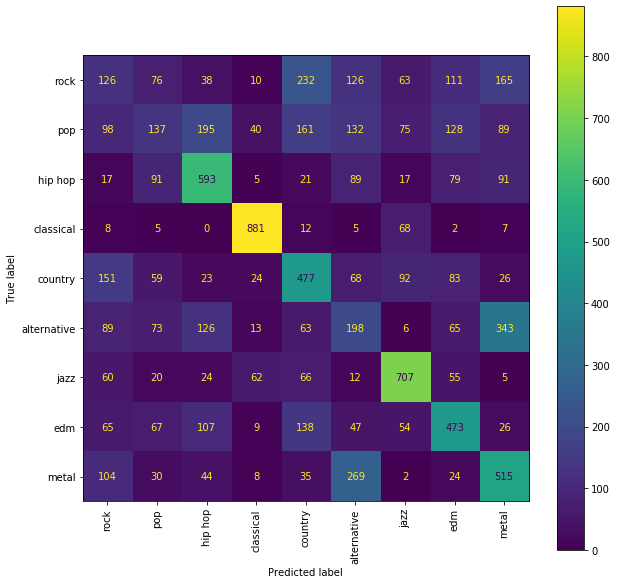

In [8]:
rf = RandomForestClassifier(n_estimators = 555, max_features = 'auto', max_depth = 24, random_state = 4).fit(X_train, y_train)
test_pred = rf.predict(X_test)
train_pred = rf.predict(X_train)

test_acc = (accuracy_score(test_pred, y_test))
test_error = 1 - test_acc
train_acc = (accuracy_score(train_pred, y_train))
train_error = (1 - train_acc)
test_prec = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
train_prec = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')

print("Test Accuracy:", test_acc)
print("Test Error:", test_error)
print("Test Recall:", test_recall)
print("Test Precision:", test_prec)
print("-----------------------------------------")
print("Train Accuracy:", train_acc)
print("Train Error:", train_error)
print("Train Recall:", train_recall)
print("Train Precision:", train_prec)
print("-----------------------------------------")

print("Training snapshot")
df = pd.DataFrame({"Actual": y_train, "Predicted": train_pred})
print(df.head())
print("Training classification report:")
print(classification_report(y_train, train_pred, labels=genres_master_list))

print("Testing snapshot")
df = pd.DataFrame({"Actual": y_test, "Predicted": test_pred})
print(df.head())
print("Testing classification report:")
print(classification_report(y_test, test_pred, labels=genres_master_list))

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(rf, X_test, y_test, labels = genres_master_list, 
                      xticks_rotation='vertical', ax = ax, values_format = 'd')
    
plt.show()


AUC Score: 0.6171875


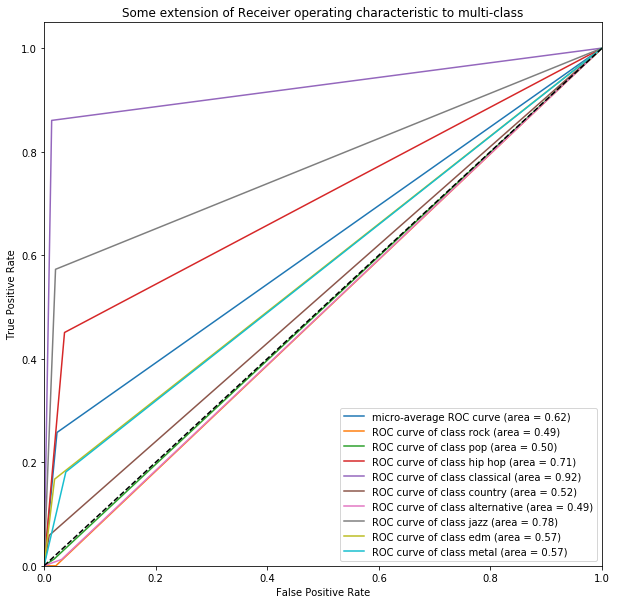

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize


# Binarize the output
y_test_bin = label_binarize(y_test, classes = genres_master_list)
y_train_bin = label_binarize(y_train, classes = genres_master_list)

# Change whats inside this to match the model you're plotting
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators = 555, max_features = 'auto', max_depth = 24, random_state = 4))
y_score = classifier.fit(X_train, y_train_bin).predict(X_test)

n_classes = 9

print("AUC Score:", roc_auc_score(y_test_bin, y_score, average = 'micro'))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(genres_master_list[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")

plt.show()